In [1]:
!git clone https://github.com/JakobUniver/Traffic-sign-detection-in-color-videos.git -q

In [2]:
!git clone https://github.com/WongKinYiu/yolov7.git -q

In [3]:
!pip install -r yolov7/requirements.txt -q

     |████████████████████████████████| 1.6 MB 35.2 MB/s 


In [4]:
#!git clone https://github.com/ultralytics/yolov3 -q

In [5]:
#!pip install -r yolov3/requirements.txt -q

In [6]:
#!rm -rf Traffic-sign-detection-in-color-videos

In [96]:
import numpy as np
import pandas as pd
import cv2
import torch
from google.colab.patches import cv2_imshow

In [15]:
#Get pretrained weigths
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt -q

In [19]:
#Train YOLOv7 on custom dataset
!python yolov7/train.py --weights yolov7.pt --data "Traffic-sign-detection-in-color-videos/data/data_yolo/traffic_signs.yaml" --workers 4 --batch-size 16 --epochs 25 --img 640 --cfg yolov7/cfg/training/yolov7.yaml --hyp yolov7/data/hyp.scratch.p5.yaml

YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='yolov7/cfg/training/yolov7.yaml', data='Traffic-sign-detection-in-color-videos/data/data_yolo/traffic_signs.yaml', device='', entity=None, epochs=25, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='yolov7/data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp6', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='yolov7.pt', workers=4, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, we

In [ ]:
#Train YOLOv3 model
#!python yolov3/train.py --img 640 --batch 16 --epochs 20 --data "Traffic-sign-detection-in-color-videos/data/data_yolo/traffic_signs.yaml" --weights yolov3.pt

In [ ]:
#Test YOLOv7
!python yolov7/detect.py --weights runs/train/exp6/weights/best.pt --source "Traffic-sign-detection-in-color-videos/data/data_yolo/test/images"

In [ ]:
#Test YOLOv3
#!python yolov3/detect.py --weights yolov3/runs/train/exp/weights/best.pt --source "Traffic-sign-detection-in-color-videos/data/data_yolo/test/images"

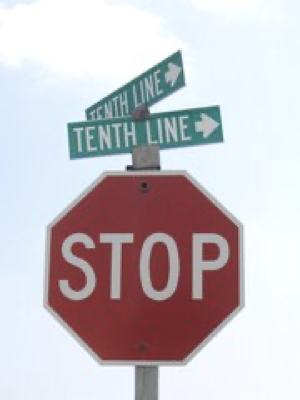

In [ ]:
img_path = "Traffic-sign-detection-in-color-videos/data/dataset1/images/road52.png"
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img.shape

(400, 300, 3)

In [ ]:
#Test image from different dataset
!python yolov3/detect.py --weights yolov3/runs/train/exp2/weights/best.pt --source "Traffic-sign-detection-in-color-videos/data/dataset1/images"

In [ ]:
#.pt to .weights conversion: https://github.com/AlexeyAB/darknet/issues/2587#issuecomment-500895636

In [ ]:
#YOLOv3 weights from https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html
cfg_path = "Traffic-sign-detection-in-color-videos/yolov3.cfg"
weights_path = "Traffic-sign-detection-in-color-videos/yolov3.weights"

In [ ]:
net = cv2.dnn.readNetFromDarknet(cfg_path, 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

In [ ]:
#Function for detecting traffic sign with YOLOv3
def detect_sign(img, net):
  blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

  ln = net.getLayerNames()
  ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

  net.setInput(blob)
  outputs = net.forward(ln)

  boxes = []
  confidences = []
  classIDs = []
  h, w = img.shape[:2]

  for output in outputs:
      for detection in output:
          scores = detection[5:]
          classID = np.argmax(scores)
          confidence = scores[classID]
          if confidence > 0.5:
              box = detection[:4] * np.array([w, h, w, h])
              (centerX, centerY, width, height) = box.astype("int")
              x = int(centerX - (width / 2))
              y = int(centerY - (height / 2))
              box = [x, y, int(width), int(height)]
              boxes.append(box)
              confidences.append(float(confidence))
              classIDs.append(classID)

  indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
  if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = (0, 0, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

  return img

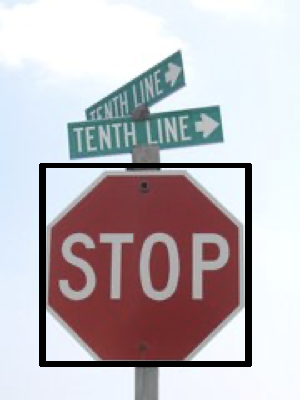

In [ ]:
cv2_imshow(detect_sign(img, net))

In [50]:
model = torch.hub.load('yolov7', 'custom', 'runs/train/exp6/weights/best.pt', source='local') 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding autoShape... 


In [100]:
result = model('Traffic-sign-detection-in-color-videos/data/dataset1/images/road221.png')

In [101]:
first = result.pandas().xyxy[0].loc[0]
result.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,130.524979,184.212509,155.186646,208.227905,0.796247,0,ts1


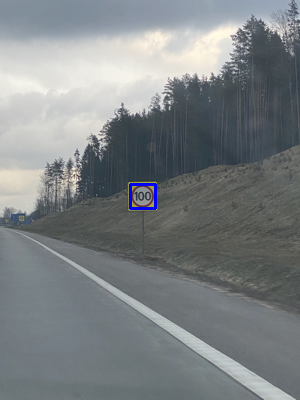

In [102]:
img = cv2.imread('Traffic-sign-detection-in-color-videos/data/dataset1/images/road221.png')
cv2.rectangle(img, (int(first.xmin), int(first.ymin)), (int(first.xmax), int(first.ymax)), (255,0,0), 2)
cv2_imshow(img)

In [103]:
img = cv2.imread('Traffic-sign-detection-in-color-videos/data/dataset1/images/road221.png')
crop = img[int(first.ymin):int(np.ceil(first.ymax)), int(first.xmin):int(np.ceil(first.xmax))]
cv2_imshow(crop)

In [104]:
#Uses YOLO model to detect traffic signs. Returns images with only traffic signs
def detect(img_path, model):
  cropped = []
  img = cv2.imread(img_path)
  detected = model(img)
  for i, d in detected.pandas().xyxy[0].iterrows():
    crop = img[int(d.ymin):int(np.ceil(d.ymax)), int(d.xmin):int(np.ceil(d.xmax))]
    cropped.append(crop)
  return cropped

In [99]:
detection = detect('Traffic-sign-detection-in-color-videos/data/dataset1/images/road212.png', model)
for det in detection:
  cv2_imshow(det)